In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection

#### Constants

In [2]:
RANDOM_SEED = 42
DICT_SIZE = 10000
TEST_SIZE = 10000
DEV_SIZE = 10000
PATH = '../data/communities/default/versions/tf-idf/'

TRAIN = False

## Preparations

Let's load dataset

In [3]:
core = pd.read_csv("../data/toxic-comment/core.csv")
core.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
id              159571 non-null object
comment_text    159571 non-null object
base_class      159571 non-null int64
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [4]:
core.head(3)

,id,comment_text,base_class
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0


In [5]:
train, test = model_selection.train_test_split(core, test_size=DICT_SIZE, random_state=RANDOM_SEED,
                                               stratify=core.loc[:, 'base_class'])
train.head(3)

,id,comment_text,base_class
71206,be97f17da5b1c3a5,"""\n\nWelcome!\n\nHello, Pieguy6, and welcome t...",0
15700,297717b8d293ff77,"""\nI looked at this very briefly, inviting use...",0
70919,bdcd1242f6b7226f,17Drew that's incredibly insulting. You fail t...,0


## Juicy part

In [6]:
from sklearn import feature_extraction
from sklearn import pipeline
from sklearn import linear_model
import nltk
import joblib

#### Data transformations

use sklearn tf-idf vectorizer

* should we treat all numbers as special token?
* should we treat all punctuation as special token?

##### Prepare vectorizer

In [7]:
if TRAIN:
    # prepare vectorizer
    custom_tokenizer = nltk.tokenize.casual.TweetTokenizer()
    callback = custom_tokenizer.tokenize
    vectorizer = feature_extraction.text.TfidfVectorizer(analyzer='word', max_features=DICT_SIZE, tokenizer=callback)

##### Prepare and train model

In [8]:
if TRAIN:
    # prepare model and make pipeline
    model = linear_model.SGDClassifier(max_iter=1000, tol=0.001, loss='log', verbose=1, n_jobs=-1)
    
    pipe = pipeline.Pipeline([
        ('vectorize', vectorizer),
        ('model', model)
    ])

In [9]:
if TRAIN:
    pipe.fit(train.loc[:, 'comment_text'], train.loc[:, 'base_class'])
    joblib.dump(pipe, f'{PATH}/pipe.joblib')
    print('Model saved on disk')

##### If not TRAIN just load pipeline

In [10]:
if not TRAIN:
    pipe = joblib.load(f'{PATH}/pipe.joblib')

## Model evaluation

In [11]:
from sklearn import metrics

##### Single number metrics

In [12]:
predicted = pipe.predict(test.loc[:, 'comment_text'])
predicted_probas = pipe.predict_proba(test.loc[:, 'comment_text'])[:, 1]
real = test.loc[:, 'base_class']

* Accuracy

In [13]:
acc = metrics.accuracy_score(predicted, real)
acc

0.9304

* Balanced accuracy

In [14]:
b_acc = metrics.balanced_accuracy_score(predicted, real)
b_acc

0.9260109379975492

* ROC-AUC

In [15]:
roc_auc = metrics.roc_auc_score(real, predicted_probas)
roc_auc

0.9452997144940334

##### Confusion matrix

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 33.0, 'Predicted label')

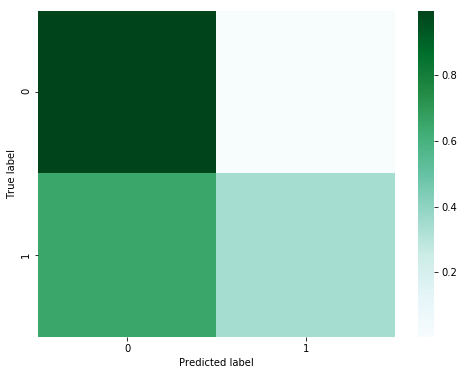

In [17]:
confusion_matrix = metrics.confusion_matrix(real, predicted)
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
# cm_df = pd.DataFrame(confusion_matrix, index=[], columns=[])
plt.figure(figsize=(8, 6))
_ = sns.heatmap(confusion_matrix, cmap='BuGn')
plt.ylabel('True label')
plt.xlabel('Predicted label')

##### Curves

* ROC

In [18]:
def plot_roc(fpr, tpr):
    plt.figure(figsize=(8, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

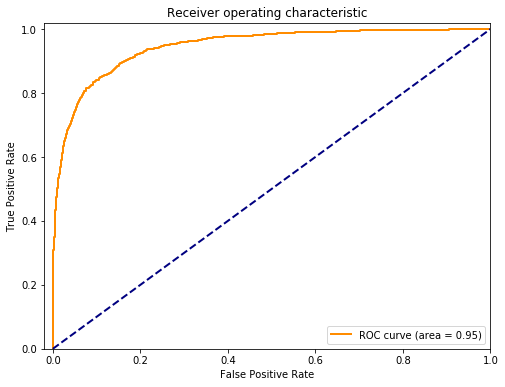

In [19]:
fpr, tpr, thresholds_roc = metrics.roc_curve(real, predicted_probas)
plot_roc(fpr, tpr)

* precision recall curve

In [20]:
def plot_prc(precision, recall):
    plt.figure(figsize=(8, 6))
    lw = 2
    plt.plot(precision, recall, color='darkorange', lw=lw, label='PR curve')
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.02])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-recall curve')
    plt.legend(loc="lower right")
    plt.show()

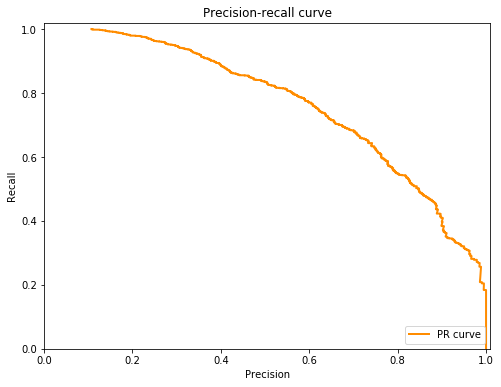

In [21]:
prec, rec, thresholds_prc = metrics.precision_recall_curve(real, predicted_probas)
plot_prc(prec, rec)